# Análise Exploratória de sinais de ECG

In [1]:
import pandas as pd
import numpy as np
import os

PATH = os.path.abspath('../../')
PATH

'/home/davi/Github/doutorado_ppgee_v2'

In [2]:
df = pd.read_csv(PATH+'/data/Generalized_seizures_dataset.csv')

# df = pd.read_csv(PATH + '/data/data_train.csv')

In [3]:
# Quantidade de Sinas por frquência amostral
df['freq'].value_counts()

256     218
250     190
400      32
1000     16
512       2
Name: freq, dtype: int64

In [4]:
# Contagem de eventos por Arquivo
df['path'].value_counts()

train/01_tcp_ar/100/00010020/s001_2013_03_23/00010020_s001_t001.tse      43
train/01_tcp_ar/100/00010020/s001_2013_03_23/00010020_s001_t000.tse      28
train/02_tcp_le/065/00006514/s008_2010_05_03/00006514_s008_t001.tse      16
train/01_tcp_ar/120/00012046/s001_2014_10_09/00012046_s001_t000.tse      13
train/02_tcp_le/065/00006514/s007_2010_05_03/00006514_s007_t001.tse      12
                                                                         ..
train/01_tcp_ar/112/00011272/s003_2014_02_19/00011272_s003_t006.tse       1
train/01_tcp_ar/118/00011870/s001_2014_08_13/00011870_s001_t002.tse       1
train/01_tcp_ar/118/00011870/s003_2014_08_13/00011870_s003_t002.tse       1
train/01_tcp_ar/127/00012707/s001_2015_01_29/00012707_s001_t001.tse       1
train/03_tcp_ar_a/119/00011999/s007_2014_11_09/00011999_s007_t004.tse     1
Name: path, Length: 200, dtype: int64

In [5]:
df = df[df['freq'] == 256].reset_index(drop=True)

In [6]:
data_ = df.iloc[0]
data_

path       train/01_tcp_ar/044/00004456/s015_2014_06_19/0...
inicio                                              325.0234
fim                                                 353.9688
tipo                                                    GNSZ
freq                                                     256
tempo                                                   1113
montage    ['EEG FP1-REF', 'EEG FP2-REF', 'EEG F3-REF', '...
Name: 0, dtype: object

In [7]:
files = df['path'].unique()

In [8]:
from dotenv import load_dotenv

load_dotenv()

PATH = os.path.abspath('')

pwd = os.getenv('TUH_PASSWORD')
user = os.getenv('TUH_USER')
path_data = os.getenv('PATH_DATASET')

In [9]:
# Carregando .edf
import mne

file = data_.path.replace('tse', 'edf')

data = mne.io.read_raw_edf(path_data + '/' + file)
info = data.info
info

Extracting EDF parameters from /media/davi/2526467b-9f07-4ce5-9425-6d2b458567b7/home/davi/www.isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_seizure/v1.5.2/edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/00004456_s015_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<Info | 7 non-empty values
 bads: []
 ch_names: EEG FP1-REF, EEG FP2-REF, EEG F3-REF, EEG F4-REF, EEG C3-REF, ...
 chs: 30 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: 2014-06-19 12:29:31 UTC
 nchan: 30
 projs: []
 sfreq: 256.0 Hz
>

In [10]:
# canais de ecg
ch_ecg = [ch for ch in info.ch_names if 'EKG' in ch]
ch_ecg

['EEG EKG1-REF']

<AxesSubplot:>

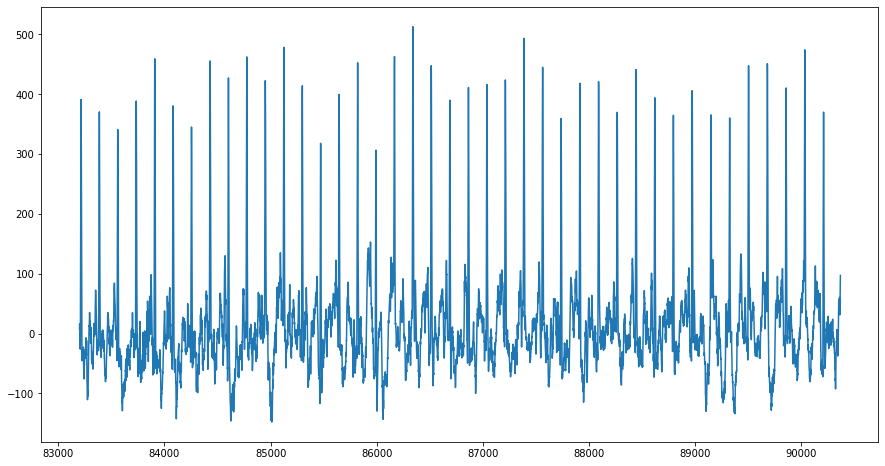

In [11]:
# Canal de ECG puro 

import matplotlib.pyplot as plt

edf = data.to_data_frame()

start = int(data_.inicio)
end = int(data_.fim)
fs = 256

ecg = edf['EEG EKG1-REF'][fs*start:fs*end]
ecg = ecg*(-1)
fig = plt.figure(figsize=[15, 8])

ecg.plot()

In [12]:
import sys 
new_path = os.path.split(os.getcwd())[0]
sys.path.append(new_path)

In [13]:
from utils import ecg_segmented_beat_modulation as SBM
from scipy.signal import find_peaks, butter, filtfilt

x = ecg.to_numpy()
fs = 256
delta_t = 40e-3 
Ts = 1/fs   # Sampling period [s].
gain = 100
f_nyquist = fs / 2
delta_t_n = delta_t * fs

# Time vector.
t = np.arange(0, len(x)*Ts, Ts)

ecg_mV = x/gain 
# Filter parameters.
n = 8 # Desired (effective) order.
f_low = 0.5 # Cut-off frequency 1 (suggested value is 0.5) [Hz]
f_high = 45 # Cut-off frequency 2 (suggested value is 45) [Hz]
# When creating the filter, we will divide the order by 2.

# This is because we will be doing forward and backward filtering later on.
# Thus, we wish to keep the original filter specification.
b, a = butter(round(n/2), [f_low/f_nyquist, f_high/f_nyquist], btype='band')

# Actual filtering.
ecg_pre = filtfilt(b, a, ecg_mV) # [mV]

# Find R peaks.
# Here, we will use a simple thresholding operation.
# However, there are better (i.e., more robust) ways to do so.
peak_threshold = 0.8;
r_peaks, r_peaks_prop = find_peaks(ecg_pre, height=peak_threshold, distance=delta_t_n)


(ecg_clean, mCC, cc_modulated) = SBM.ecg_segmented_beat_modulation_noise_removal(
    ecg_pre, 256, r_peaks, delta_t)

ValueError: invalid number of data points (0) specified

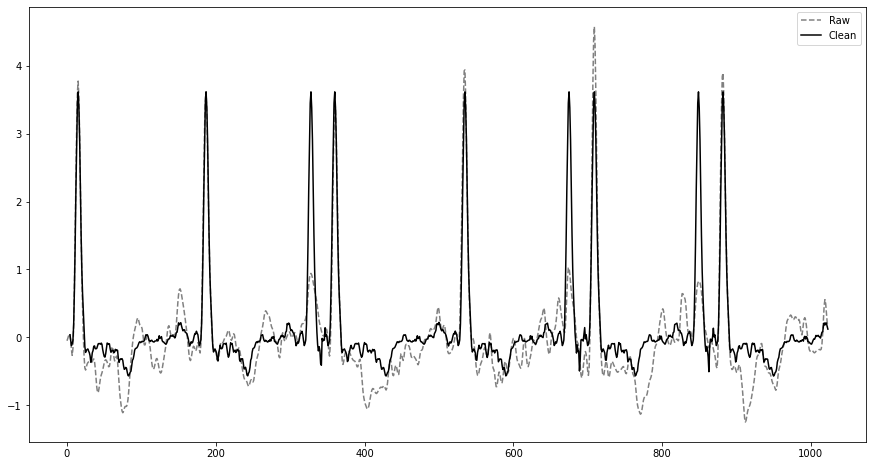

In [71]:
fig = plt.figure(figsize=[15, 8])

ecg_clean2 = np.full_like(ecg_mV, np.nan)
ecg_clean2[int(r_peaks[0]-delta_t_n):int(r_peaks[0]-delta_t_n+len(ecg_clean))] = ecg_clean

plt.plot(ecg_pre[:256*4], '--',color='gray',label='Raw')
# plt.plot(ecg_mV[:256*4],color='black',label='Pre-processed')
plt.plot(ecg_clean2[:256*4],color='black',label='Clean')
plt.legend()

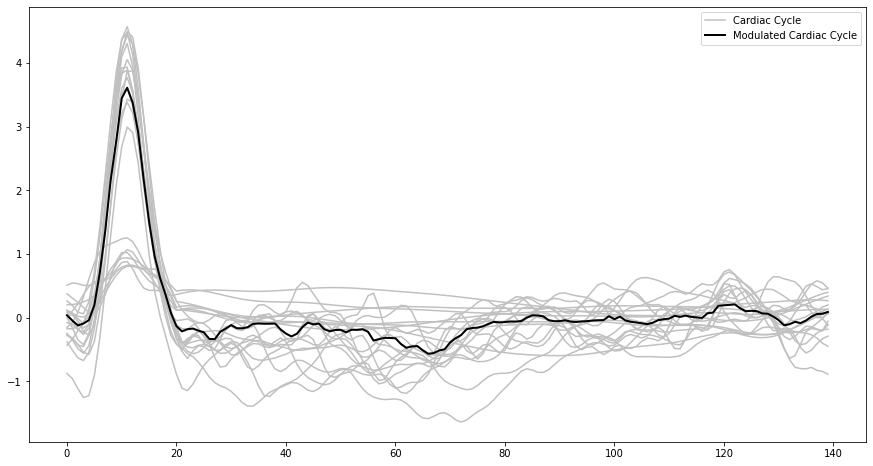

In [72]:
fig = plt.figure(figsize=[15, 8])

for i in range(len(cc_modulated)-1):
    plt.plot(cc_modulated[i],color='silver')
plt.plot(cc_modulated[-1],color='silver',label='Cardiac Cycle')
plt.plot(mCC,color='black',linewidth=2,label='Modulated Cardiac Cycle')
plt.legend()

In [35]:
r_peaks

array([   58,   286,   505,   749,  1006,  1234,  1455,  1697,  1946,
        2172,  2398,  2642,  2899,  3151,  3393,  3655,  3923,  4165,
        4219,  4396,  4650,  4923,  5171,  5398,  5660,  5935,  6188,
        6240,  6418,  6660,  6913,  7151,  7206,  7375,  7615,  7874,
        8132,  8365,  8605,  8862,  9128,  9359,  9417,  9585,  9829,
       10089])

In [34]:
from neurokit2.ecg.ecg_segment import _ecg_segment_window

epochs_start, epochs_end = _ecg_segment_window(
    rpeaks = r_peaks, 
    sampling_rate = 256, 
    desired_length = len(ecg_clean))
    
# h = ecg_segment(ecg_clean,r_peaks,256)


ValueError: NeuroKit error: desired_length must be None or larger than the index of the last peak.

In [32]:
!pip install biosppy

     |████████████████████████████████| 85 kB 581 kB/s 
     |████████████████████████████████| 4.5 MB 1.1 MB/s 
     |████████████████████████████████| 49.9 MB 68 kB/s 
  Created wheel for biosppy: filename=biosppy-0.7.3-py2.py3-none-any.whl size=95409 sha256=1d5f754b87d591887eea9015e79e68a136ff3e50867aaf2aec6c56de65375168
  Stored in directory: /home/davi/.cache/pip/wheels/9f/e5/6b/95cda9da98a09d4d42ec8f4bfa6bcf9f768dd99d83c4e8d403
Successfully built biosppy


In [21]:
ecg_clean

[-0.1557153122899326,
 -0.27041672033918257,
 -0.4053623374449413,
 -0.6280614318275243,
 -0.9161123360467789,
 -1.1116133562982176,
 -0.9476340537447683,
 -0.24085789537531982,
 0.9310998247729354,
 2.3444739244670703,
 3.501623725728116,
 3.7966712409869623,
 3.510231649966683,
 2.8085819880274743,
 2.0281896571448086,
 1.2920479369006423,
 0.6639645256138408,
 0.22591523121027846,
 -0.09485651405743092,
 -0.2223209365221936,
 -0.2217578924400798,
 -0.2014460796404646,
 -0.16593693588147643,
 -0.17654874635718784,
 -0.18006448036917963,
 -0.2034709218507635,
 -0.2262554133417522,
 -0.1997214435574203,
 -0.2026605438294061,
 -0.22665273821188925,
 -0.24293349825638136,
 -0.20621185959352745,
 -0.2193280598645144,
 -0.18449521052037102,
 -0.16676678017310217,
 -0.16435747321934652,
 -0.16865641677954135,
 -0.1839077408924174,
 -0.19532385824032447,
 -0.18021794877350814,
 -0.15021494149173023,
 -0.1469731065296975,
 -0.14267017560347842,
 -0.14192749599086055,
 -0.12321077950579405,
 -